# Kelvin Wave Precipitation Reconstruction

## import package

In [28]:
import numpy as np
import joblib as jl
import netCDF4 as nc
import matplotlib.pyplot as plt

## Functions

### FFT

In [29]:
def FFT(data):
    data_fft = np.fft.fftshift(np.fft.fft2(data))[:, ::-1]
    
    return data_fft

### Kelvin dispersion

In [30]:
def Kelvin_dispersion(ed, wn):
    return wn * (86400/(2*np.pi*6.371e6)) * np.sqrt(9.81*ed)

### Bandpass Filter

In [31]:
def Kelvin_pass(fft_data):
    wn = np.linspace(-64, 64, 128)
    fr = np.linspace(-39000, 39000, 78000)
    
    wnm, frm = np.meshgrid(wn, fr)
    
    condition = (
        (wnm >= 1) & (wnm <= 6) &
        (frm >= 1/20) & (frm <= 1/2.5) &
        (frm <= Kelvin_dispersion(90, wnm)) &
        (frm >= Kelvin_dispersion(8, wnm))
    )
    
    data_filtered = np.where(condition, fft_data*2, 0)
    
    return data_filtered

## Load data

In [32]:
# case name
case = 'pr0'

# file name
fname = f'/work/b11209013/2024_Research/Dycore/{case}/prec_{case}.nc'

# read data
with nc.Dataset(fname, 'r', mmap=True) as f:
    lon  = f.variables['lon'][:]
    lat  = f.variables['lat'][:]
    time = f.variables['time'][:]
    prec = f.variables['prec'][:]*86400
    
prec = prec - prec.mean()

## Apply FFT on Precipitation Dataset

### FFT on the precipitation data

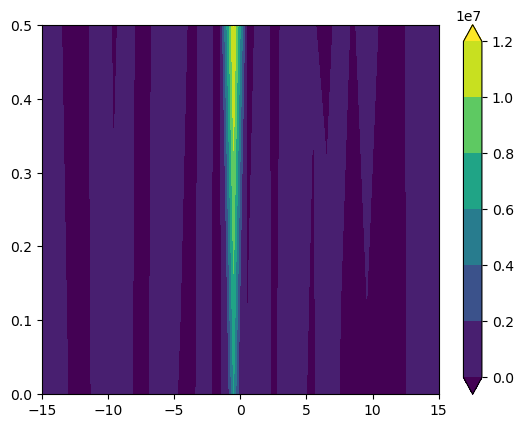

In [33]:
prec_fft = jl.Parallel(n_jobs=32)(
    jl.delayed(FFT)(prec[:, i, :])
    for i in range(prec.shape[1])
    )

prec_fft = np.stack(prec_fft, axis=1)

wn = np.linspace(-64, 64, 128)
fr = np.linspace(-39000, 39000, 78000)
    
wnm, frm = np.meshgrid(wn, fr)


plt.contourf(wnm, frm, (prec_fft[:, 5, :].real), extend='both')
plt.xlim(-15, 15)
plt.ylim(0, 1/2)
plt.colorbar()

### Apply Kelvin wave Bandpass filter

/tmp/ipykernel_4066546/3955114813.py:14: RuntimeWarning: divide by zero encountered in log
  plt.contourf(wnm, frm, np.log(prec_filtered[:, 0, :].real))


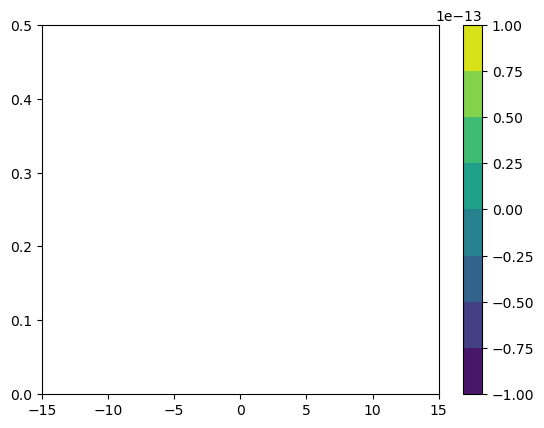

In [34]:
prec_filtered = jl.Parallel(n_jobs=32)(
    jl.delayed(Kelvin_pass)(prec_fft[:, i, :])
    for i in range(prec_fft.shape[1])
    )

prec_filtered = np.stack(prec_filtered, axis=1)

wn = np.linspace(-64, 64, 128)
fr = np.linspace(-39000, 39000, 78000)
    
wnm, frm = np.meshgrid(wn, fr)


plt.contourf(wnm, frm, np.log(prec_filtered[:, 0, :].real))
plt.xlim(-15, 15)
plt.ylim(0, 1/2)
plt.colorbar()